In [1]:
from game import controlled_run

pygame 2.0.1 (SDL 2.0.14, Python 3.8.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
import numpy as np
from game import DO_NOTHING
from game import JUMP

import matplotlib.pyplot as plt

import tensorflow 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from game import controlled_run

import random
import numpy as np
from collections import deque


In [3]:
games_count = 0
total_number_of_games = 20

# flaw in game design, it should be based on whether or not you make it past an opponent
class Wrapper(object):
    
    def __init__(self,dqn_solver):
        self.dqn_solver = dqn_solver
        self.scores=[]
        self.rewards=[]
        controlled_run(self,0)
        
    def control(self,values):
        dqn_solver = self.dqn_solver
        state = [[values['closest_enemy']/1000]]
        step = 0 

        self.old_state = state
        action = dqn_solver.act(state)
        self.action = action
        
        return action
    
    def get_scores(self):
        return self.scores
    
    def get_rewards(self):
        return self.rewards

    def setPlayer(self,player):
        self.player = player

    def setEnemy(self,enemy):
        self.enemy = enemy
    
    def setCurrentScore(self,score):
        self.currentScore = score

    def reward(self,values):
        from game import Enemy
        dqn_solver = self.dqn_solver

        state_next = values['closest_enemy']
        print(values['old_closest_enemy']+Enemy.base, self.player.x,values['closest_enemy'])
        reward = 0#self.currentScore
        if(values['old_closest_enemy']+Enemy.base < 400 and values['old_closest_enemy']+Enemy.base != 24):
            reward = self.currentScore+ 20
            print("Rewarded for Jumping Over!")
        self.rewards.append(reward)
        terminal=False
        try:
            self.state = state_next
            dqn_solver.remember(self.old_state, self.action, reward, [state_next], terminal)
            if(games_count < 50):
                dqn_solver.experience_replay(False)
            print("Replayed!")
            # print("remembered")
        except:
            pass
        
    def gameover(self,score):
        global games_count
        dqn_solver = self.dqn_solver
        reward = -10
        dqn_solver.remember(self.old_state, self.action, reward, self.state, True)
        try:
            print("Run: " + str(games_count) + ", exploration: " + str(dqn_solver.exploration_rate) + ", score: " + str(score))
        except:
            print("Run: " + str(games_count) + ", score: " + str(score))
        
        if(games_count >0 and games_count < 50):
            dqn_solver.experience_replay(True)

        games_count+=1
        self.scores.append(score)
        print("Score: " + str(score))
        if games_count>total_number_of_games: 
            return
        controlled_run(self,games_count)

In [4]:
gamma = 0.95
alpha = 0.2
learning_rate_adam = 0.1
epsilon = 0.80
epsilon_decay = 0.9
class DQN:

    def __init__(self, observation_space, action_space):
        
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.action_space = action_space
        self.observation_space = observation_space
        
        self.memory = []
        self.batch_size = 64

        #model
        self.model = Sequential()
        self.model.add(Dense(4, input_shape=(observation_space,), activation="elu", kernel_initializer='he_normal'))
        self.model.add(BatchNormalization())
        #self.model.add(Dense(64, activation="relu"))
        #self.model.add(BatchNormalization())
        #self.model.add(Dense(32, activation="relu"))
        #self.model.add(Dense(16, activation="relu", kernel_initializer='he_uniform'))
        self.model.add(Dense(8, activation="elu", kernel_initializer='he_normal'))
        #self.model.add(BatchNormalization())
        self.model.add(Dense(16, activation="elu", kernel_initializer='he_normal'))
        self.model.add(Dense(8, activation="elu", kernel_initializer='he_normal'))
        self.model.add(Dense(4, activation="elu", kernel_initializer='he_normal'))

        #self.model.add(Dropout(0.1))
        self.model.add(BatchNormalization())
        self.model.add(Dense(self.action_space, activation="linear"))
        self.model.compile(loss="mse", optimizer=Adam(lr=learning_rate_adam))
        
    def act(self, state):
        if np.random.rand() < self.epsilon:
            print("RANDOM!")
            return random.randrange(self.action_space)
        q = self.model.predict(state)
        print("Measured")
        return np.argmax(q[0])

    def experience_replay(self,terminal=False):
        # print(self.memory,self.batch_size)
        mem_sample = random.sample(self.memory, min(len(self.memory),self.batch_size))
        if(terminal==True):
            done=True
        else:
            done=False
        for state, action, reward, next_state, done in mem_sample:
            print("Done: " + str(done))
            update_value = reward
            # print(update_value)
            if not done:
                # print("Discounting")
                update_value = self.alpha * (reward + self.gamma * np.max(self.model.predict(next_state)[0]))
            q = self.model.predict(state)
            q[0][action] = update_value
            # print(state,type(state))
            # print(q,type(q))
            self.model.fit(np.array(state), q, verbose=0)
        self.epsilon *= epsilon_decay
        print("Epsilon: " + str(self.epsilon))

        
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

In [7]:
dqn_solver = DQN(1,2)
game = Wrapper(dqn_solver)

: False
Done: False
Done: False
Done: False
Done: False
Done: False
Done: False
Epsilon: 2.9148311536447243e-05
Replayed!
Measured
326 100 652
Rewarded for Jumping Over!
Done: False
Done: False
Done: False
Done: False
Done: False
Done: False
Done: False
Done: False
Epsilon: 2.6233480382802518e-05
Replayed!
Measured
677 100 343
Done: False
Done: False
Done: False
Done: False
Done: False
Done: False
Done: False
Done: False
Epsilon: 2.3610132344522266e-05
Replayed!
Measured
368 100 1000
Rewarded for Jumping Over!
Done: False
Done: True
Done: False
Done: False
Done: False
Done: False
Done: False
Done: False
Epsilon: 2.124911911007004e-05
Replayed!
Measured
1025 100 916
Done: False
Done: False
Done: False
Done: False
Done: False
Done: False
Done: False
Done: False
Epsilon: 1.9124207199063037e-05
Replayed!
Measured
941 100 607
Done: False
Done: False
Done: False
Done: False
Done: True
Done: False
Done: False
Done: False
Epsilon: 1.7211786479156735e-05
Replayed!
Measured
632 100 298
Done: Fal

In [9]:
scores = game.get_scores()

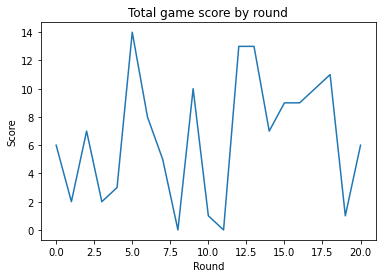

In [10]:
plt.plot(scores)
plt.xlabel('Round')
plt.ylabel('Score')
plt.title('Total game score by round')
plt.show()

In [11]:
scores_start = scores[:50]

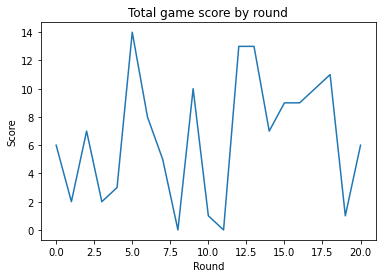

In [12]:
plt.plot(scores_start)
plt.xlabel('Round')
plt.ylabel('Score')
plt.title('Total game score by round')
plt.show()

In [12]:
rewards = np.array(game.get_rewards()).T

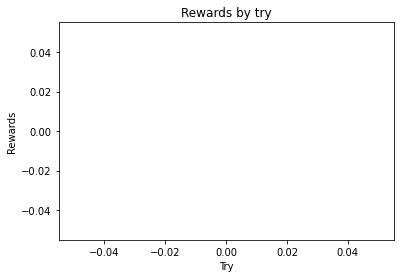

In [13]:
plt.plot(rewards)
plt.xlabel('Try')
plt.ylabel('Rewards')
plt.title('Rewards by try')
plt.show()